# 인공지능으로 세상에 없던 새로운 패션 만들기(DCGAN 활용해보기)

In [107]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.9.2


In [108]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [109]:
# 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [110]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

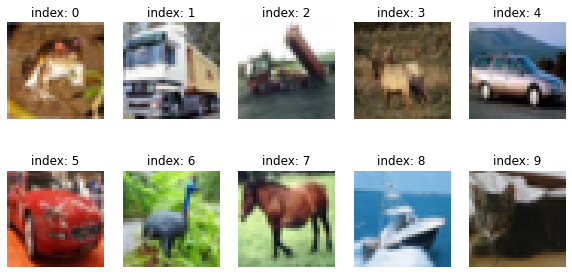

In [111]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i].reshape(32, 32, 3)+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [112]:
# Shuffle 기법중 하나인 BUFFER_SIZE -> 최소 20000부터 시작하는 것이 좋다.
BUFFER_SIZE = 50000
BATCH_SIZE = 256

# 효율적 학습을 위해 배치사이즈를 잘라 한번에 학습할 양을 구분짓는다
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

 # DCGAN

In [113]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 가중치 값을 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    # tanh를 쓴 이유 : -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) 

    return model

![con](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/convol.png?raw=true)

- 일반적인 컨볼루션 계산 방법

![tranpos](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/convoltranpose.png?raw=true)


- Conv2DTranspose의 계산 방법


> input의 빨간색, 파란색 요소를 3x3 kernel에 곱해서 output의 대응하는 자리에 집어넣는다. 그리고 output에 겹치는 구간(빗금 표시)이 발생하는데, 교집합으로 모든 값을 더해준다.. input의 나머지 원소에 대해서도 동일한 방법으로 계산한다.


In [114]:
generator = make_generator_model()
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_12 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 128)       

In [115]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
noise = tf.random.normal([1, 100])

In [116]:
# 학습이 아니기때문에 False값을 주었다
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

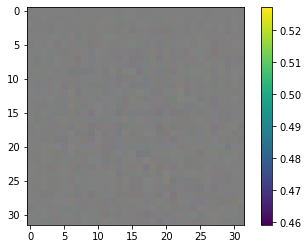

In [117]:
# matplotlib 라이브러리는 2차원 이미지만 출력가능하므로 0번째와 3번째 축의 인덱스를 0으로 설정
plt.imshow((generated_image[0]+1)/2)
plt.colorbar()
plt.show()

# 판별자 모델 구현하기

In [118]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(3))

    return model

In [119]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)             

In [120]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 2.9106578e-03,  1.7284625e-04, -3.1837379e-05]], dtype=float32)>

In [121]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 손실함수와 최적화 함수 구현하기

In [122]:
# 생성자 손실함수
# ones_like는 특정 벡터와 동일한 크기이면서 값은 1으로 가득 채워진 벡터를 만들고 싶을 때 사용
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [123]:
# 판별자 손실함수
# zeros_like는 특정 벡터와 동일한 크기이면서 값은 0으로 가득 채워진 벡터를 만들고 싶을 때 사용
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [124]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [125]:
# 생성자와 판별자는 따로 제작(러닝레이트랑 베타값은 같게 하는게 좋은듯?)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# Train

In [126]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [127]:
@tf.function # 텐서플로우 function을 사용함으로써 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [128]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2)
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/exploration/Ex11/epoch_sample/sample_epoch_{:04d}_iter_{:03d}.png')

    plt.show()

In [129]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig('/content/drive/MyDrive/exploration/Ex11/train_history/train_history_{:04d}.png')
    
    plt.show()

In [130]:
# 중간 체크포인트
checkpoint_dir = '/content/drive/MyDrive/exploration/Ex11/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [131]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

# 1e-4

In [79]:
save_every = 5
EPOCHS = 50

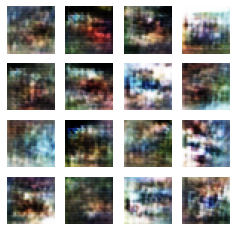

Time for training : 733 sec


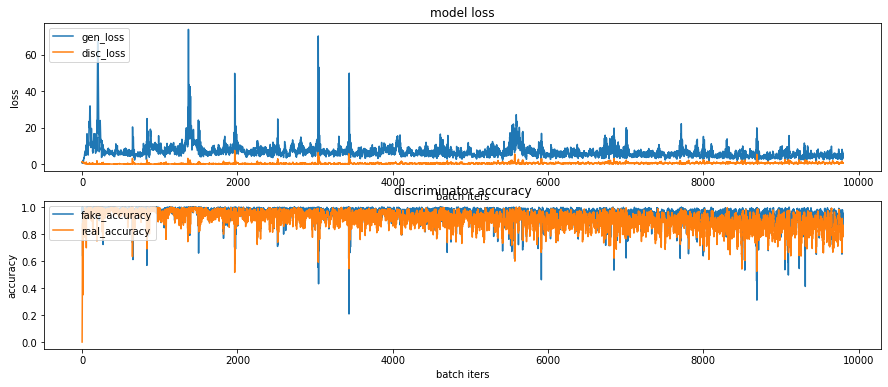

CPU times: user 4min 22s, sys: 29.1 s, total: 4min 51s
Wall time: 12min 14s


In [80]:
%%time
train(train_dataset, EPOCHS, save_every)

- fake, real 정확도가 엉망이다
- 로스도 최대 70가까이 갔다.

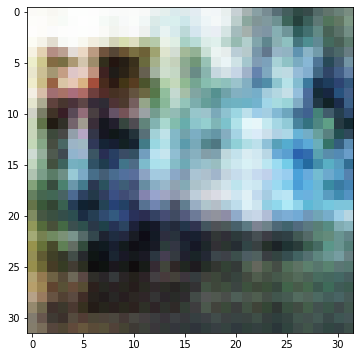

In [82]:
checkpoint_dir = '/content/drive/MyDrive/exploration/Ex11/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # 복구를 위한 renormalization
np_generated = np_generated.astype(int) 
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질이다.

- 최종 결과가 나오긴 했는데 이미지가 별로 만족스럽지가 않다.

# 2e-4, 0.5

adam의 입실론을 0.0002, 베타값을 0.5로 두고 실행

In [132]:
save_every = 5
EPOCHS = 50

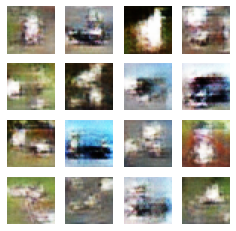

Time for training : 740 sec


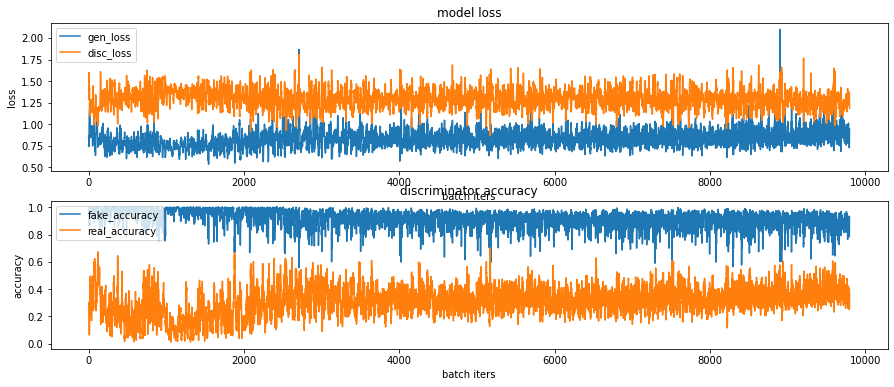

CPU times: user 4min 23s, sys: 33.2 s, total: 4min 56s
Wall time: 12min 21s


In [134]:
%%time
train(train_dataset, EPOCHS, save_every)

- 전반적으로 로스값이 안적된 것을 확인 가능하다.
- 정확도 역시 완벽하지는 않지만 fake와 real의 합이 1에 가까워지는 모습이 보인다.

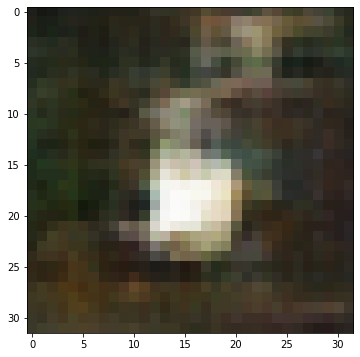

In [135]:
checkpoint_dir = '/content/drive/MyDrive/exploration/Ex11/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # 복구를 위한 renormalization
np_generated = np_generated.astype(int) 
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질이다.

- 최종 결과물

# 회고

1e-4 진행 시퀀스

![1](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/1e-4.gif?raw=true)


---

2e-4, 0.5 진행 시퀀스

![2](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/2e-4,0.5.gif?raw=true)

---

DCGAN의 프레임 워크에 대해 맛을 볼 수 있었던 Ex였다. 조금 아쉬운건 학습에 시간이 너무 걸려서 epoch를 50으로 맞추고 진행을 할 수 밖에 없어서, 결과물이 아주 만족스럽게 나올수가 없었다. 어찌 되었든 간에 이번 Ex를 통해서 각 레이어층의 활성화 함수의 메커니즘이나 활용도에 대해 많이 이해를 할 수 있어서 좋았다. 